<a href="https://colab.research.google.com/github/kcw0331/Deeplearning/blob/main/6_1_using_word_embeddings(%EA%B9%80%EC%B0%BD%EC%9A%B0)4%EC%9B%9421%EC%9D%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow
tensorflow.keras.__version__

'2.4.0'

In [ ]:
tensorflow.executing_eagerly()

True

# Using word embeddings

This notebook contains the second code sample found in Chapter 6, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---


Another popular and powerful way to associate a vector with a word is the use of dense "word vectors", also called "word embeddings". 
While the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros) and very high-dimensional (same dimensionality as the 
number of words in the vocabulary), "word embeddings" are low-dimensional floating point vectors 
(i.e. "dense" vectors, as opposed to sparse vectors). 
Unlike word vectors obtained via one-hot encoding, word embeddings are learned from data. 
It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when dealing with very large vocabularies. 
On the other hand, one-hot encoding words generally leads to vectors that are 20,000-dimensional or higher (capturing a vocabulary of 20,000 
token in this case). So, word embeddings pack more information into far fewer dimensions. 

![word embeddings vs. one hot encoding](https://s3.amazonaws.com/book.keras.io/img/ch6/word_embeddings.png)

There are two ways to obtain word embeddings:

* Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction). 
In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
* Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. 
These are called "pre-trained word embeddings". 

Let's take a look at both.

## Learning word embeddings with the `Embedding` layer


The simplest way to associate a dense vector to a word would be to pick the vector at random. The problem with this approach is that the 
resulting embedding space would have no structure: for instance, the words "accurate" and "exact" may end up with completely different 
embeddings, even though they are interchangeable in most sentences. It would be very difficult for a deep neural network to make sense of 
such a noisy, unstructured embedding space. 

To get a bit more abstract: the geometric relationships between word vectors should reflect the semantic relationships between these words. 
Word embeddings are meant to map human language into a geometric space. For instance, in a reasonable embedding space, we would expect 
synonyms to be embedded into similar word vectors, and in general we would expect the geometric distance (e.g. L2 distance) between any two 
word vectors to relate to the semantic distance of the associated words (words meaning very different things would be embedded to points 
far away from each other, while related words would be closer). Even beyond mere distance, we may want specific __directions__ in the 
embedding space to be meaningful. 

[...]


In real-world word embedding spaces, common examples of meaningful geometric transformations are "gender vectors" and "plural vector". For 
instance, by adding a "female vector" to the vector "king", one obtain the vector "queen". By adding a "plural vector", one obtain "kings". 
Word embedding spaces typically feature thousands of such interpretable and potentially useful vectors.

Is there some "ideal" word embedding space that would perfectly map human language and could be used for any natural language processing 
task? Possibly, but in any case, we have yet to compute anything of the sort. Also, there isn't such a thing as "human language", there are 
many different languages and they are not isomorphic, as a language is the reflection of a specific culture and a specific context. But more 
pragmatically, what makes a good word embedding space depends heavily on your task: the perfect word embedding space for an 
English-language movie review sentiment analysis model may look very different from the perfect embedding space for an English-language 
legal document classification model, because the importance of certain semantic relationships varies from task to task.

It is thus reasonable to __learn__ a new embedding space with every new task. Thankfully, backpropagation makes this really easy, and Keras makes it 
even easier. It's just about learning the weights of a layer: the `Embedding` layer.

- 교수님이 word embeding을 하려면 embeding layer를 추가해주는 방법을 사용해준다고 말씀하심.

In [ ]:
from tensorflow.keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)  #그래서 모형을 define 할 때, embeding_layer를 넣어주는 방식으로 한다고 말씀하심.


The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes 
as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.


The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of 
integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have 
shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). All sequences in a batch must 
have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded 
with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then 
be processed by a RNN layer or a 1D convolution layer (both will be introduced in the next sections).

When you instantiate an `Embedding` layer, its weights (its internal dictionary of token vectors) are initially random, just like with any 
other layer. During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the 
downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for 
the specific problem you were training your model for.

Let's apply this idea to the IMDB movie review sentiment prediction task that you are already familiar with. Let's quickly prepare 
the data. We will restrict the movie reviews to the top 10,000 most common words (like we did the first time we worked with this dataset), 
and cut the reviews after only 20 words. Our network will simply learn 8-dimensional embeddings for each of the 10,000 words, turn the 
input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single `Dense` 
layer on top for classification.

- 예제에서 IMDB데이터를 읽어 올 때, 10000개의 most common words로 해당 데이터를 읽어 온다. 

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)


17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

- maxlen = 20이걸 사용했기 때문에 x_train, x_test를 해주게 되면 len이 20개가 나오는 것을 볼 수 있다. 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))  #maxlen을 해줘서 20개의 token index를 준다. 그럼 그 token index를 8차원 공간에 embeding시켜가지고 성능을 살펴보는 것이다.
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())  #embeding만 해가지고 바로 Flatten시켜가지고 

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))  #output해주는 레이어를 달아서 결과를 냈다. 
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 2s 2ms/step - loss: 0.6867 - acc: 0.5559 - val_loss: 0.6225 - val_acc: 0.6958
Epoch 2/10
625/625 [==============================] - 1s 1ms/step - loss: 0.5743 - acc: 0.7466 - val_loss: 0.5265 - val_acc: 0.7298
Epoch 3/10
625/625 [==============================] - 1s 1ms/step - loss: 0.4702 - acc: 0.7858 - val_loss: 0.5008 - 

- 이런 애들을 딥러닝 모형에 넣는데, embeding_layer를 사용해가지고 word embeding 실습을 해보는 것이다. 
- 그리고 마지막 결과를 보았을 때, val_acc가 74%가 되는 것을 볼 수 있다. 모든 review에 앞에 20단어만 보았을 때, 74%정도의 정확도로 판단하는게 나쁘지는 않다고 하심. 그래서 이런정도의 성능을 확인 할 수 있었다. 
- 그리고 나중에 recurrent layers 나 1D convolutional layers를 배우면 더 성능이 좋아지는 것을 기대해 볼 수 있다고 말씀하심.

We get to a validation accuracy of ~76%, which is pretty good considering that we only look at the first 20 words in every review. But 
note that merely flattening the embedded sequences and training a single `Dense` layer on top leads to a model that treats each word in the 
input sequence separately, without considering inter-word relationships and structure sentence (e.g. it would likely treat both _"this movie 
is shit"_ and _"this movie is the shit"_ as being negative "reviews"). It would be much better to add recurrent layers or 1D convolutional 
layers on top of the embedded sequences to learn features that take into account each sequence as a whole. That's what we will focus on in 
the next few sections.

## Using pre-trained word embeddings


Sometimes, you have so little training data available that could never use your data alone to learn an appropriate task-specific embedding 
of your vocabulary. What to do then?

Instead of learning word embeddings jointly with the problem you want to solve, you could be loading embedding vectors from a pre-computed 
embedding space known to be highly structured and to exhibit useful properties -- that captures generic aspects of language structure. The 
rationale behind using pre-trained word embeddings in natural language processing is very much the same as for using pre-trained convnets 
in image classification: we don't have enough data available to learn truly powerful features on our own, but we expect the features that 
we need to be fairly generic, i.e. common visual features or semantic features. In this case it makes sense to reuse features learned on a 
different problem.

Such word embeddings are generally computed using word occurrence statistics (observations about what words co-occur in sentences or 
documents), using a variety of techniques, some involving neural networks, others not. The idea of a dense, low-dimensional embedding space 
for words, computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s, but it only started really taking 
off in research and industry applications after the release of one of the most famous and successful word embedding scheme: the Word2Vec 
algorithm, developed by Mikolov at Google in 2013. Word2Vec dimensions capture specific semantic properties, e.g. gender.

There are various pre-computed databases of word embeddings that can download and start using in a Keras `Embedding` layer. Word2Vec is one 
of them. Another popular one is called "GloVe", developed by Stanford researchers in 2014. It stands for "Global Vectors for Word 
Representation", and it is an embedding technique based on factorizing a matrix of word co-occurrence statistics. Its developers have made 
available pre-computed embeddings for millions of English tokens, obtained from Wikipedia data or from Common Crawl data.

Let's take a look at how you can get started using GloVe embeddings in a Keras model. The same method will of course be valid for Word2Vec 
embeddings or any other word embedding database that you can download. We will also use this example to refresh the text tokenization 
techniques we introduced a few paragraphs ago: we will start from raw text, and work our way up.

## Putting it all together: from raw text to word embeddings


We will be using a model similar to the one we just went over -- embedding sentences in sequences of vectors, flattening them and training a 
`Dense` layer on top. But we will do it using pre-trained word embeddings, and instead of using the pre-tokenized IMDB data packaged in 
Keras, we will start from scratch, by downloading the original text data.

### Download the IMDB data as raw text


First, head to `http://ai.stanford.edu/~amaas/data/sentiment/` and download the raw IMDB dataset (if the URL isn't working anymore, just 
Google "IMDB dataset"). Uncompress it.

Now let's collect the individual training reviews into a list of strings, one string per review, and let's also collect the review labels 
(positive / negative) into a `labels` list:

In [ ]:
import os

#imdb_dir = '/home/Data/aclImdb'
imdb_dir = '/Users/김창우/Desktop/data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []   #여기있는 labels과 texts에 append를 시켜서 데이터를 정리해준다. 
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='UTF-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [ ]:
len(labels)   #여기에는 25000개의 labels이있고 

25000

In [ ]:
sum(labels)   #25000개 중에서 반은 positive이고 반은 negative이다. 그래서 완전 밸런스된 데이터이다.   

12500

In [ ]:
dir_name   #어떤식으로 파일이 구성되어 있는지를 dir_name으로 해서 볼 수 있다.

'/Users/김창우/Desktop/data/aclImdb\\train\\pos'

In [ ]:
os.listdir(dir_name)

['0_9.txt',
 '10000_8.txt',
 '10001_10.txt',
 '10002_7.txt',
 '10003_8.txt',
 '10004_8.txt',
 '10005_7.txt',
 '10006_7.txt',
 '10007_7.txt',
 '10008_7.txt',
 '10009_9.txt',
 '1000_8.txt',
 '10010_7.txt',
 '10011_9.txt',
 '10012_8.txt',
 '10013_7.txt',
 '10014_8.txt',
 '10015_8.txt',
 '10016_8.txt',
 '10017_9.txt',
 '10018_8.txt',
 '10019_8.txt',
 '1001_8.txt',
 '10020_8.txt',
 '10021_8.txt',
 '10022_7.txt',
 '10023_9.txt',
 '10024_9.txt',
 '10025_9.txt',
 '10026_7.txt',
 '10027_7.txt',
 '10028_10.txt',
 '10029_10.txt',
 '1002_7.txt',
 '10030_10.txt',
 '10031_10.txt',
 '10032_10.txt',
 '10033_10.txt',
 '10034_8.txt',
 '10035_9.txt',
 '10036_8.txt',
 '10037_9.txt',
 '10038_10.txt',
 '10039_10.txt',
 '1003_10.txt',
 '10040_10.txt',
 '10041_10.txt',
 '10042_10.txt',
 '10043_10.txt',
 '10044_9.txt',
 '10045_10.txt',
 '10046_9.txt',
 '10047_10.txt',
 '10048_10.txt',
 '10049_8.txt',
 '1004_7.txt',
 '10050_10.txt',
 '10051_10.txt',
 '10052_10.txt',
 '10053_8.txt',
 '10054_10.txt',
 '10055_7.tx

In [ ]:
!cat /Users/김창우/Desktop/data/aclImdb/train/pos/0_9.txt   #원래는 !cat하게 되면 movie 리뷰에 대한 내용이 나오게 된다.

'cat'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


### Tokenize the data


Let's vectorize the texts we collected, and prepare a training and validation split.
We will merely be using the concepts we introduced earlier in this section.

Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, 
task-specific embeddings are likely to outperform them), we will add the following twist: we restrict the training data to its first 200 
samples. So we will be learning to classify movie reviews after looking at just 200 examples...


- 여기에서는 keras에 있는 Tokenizer를 사용해서 preprocessing하는 부분이다. 

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words  #movie리뷰에서 앞에서 100단어를 사용할 것이다. 
training_samples = 200  # We will be training on 200 samples  #여기에서는 training_saples이 작은데도 pretrain을 잘 할 수 있을까 하는 거다.
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset #자주 사용되는 단어는 10000개를 사용할 것이다. 

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)  #Tokenizer를 정의를 한 다음에 texts에서 25000개의 전체 텍스트로 이 tokenizer에서 정의한 것을 fitting시켜준다. 
sequences = tokenizer.texts_to_sequences(texts) #text데이터를 sequences로 바꾼게 이부분이다. 

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)  #pad_sequences이거를 사용해서 maxlen으로 끊겠다는 것이다. 
#25000개의 데이터를 앞에서 100개로 끊은게 바로 위에있는 data 코드이다. 

labels = np.asarray(labels)   #여기에서 labels의 정보를 출력해 주었다.
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]   #여기에서는 shuffle해줘서 데이터를 섞어준 다음에 
labels = labels[indices]

x_train = data[:training_samples]  #앞에서 200개를 끊어서 train set으로 쓰고 
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples] #그다음 여기서 부터는 validation_sample로 끊어서 validation set으로 쓰겠다는 것이다. 
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [ ]:
len(sequences[0])

104

In [ ]:
data.shape  #data의 shape이 25000개에서 100차원으로 

(25000, 100)

### Download the GloVe word embeddings


Head to `https://nlp.stanford.edu/projects/glove/` (where you can learn more about the GloVe algorithm), and download the pre-computed 
embeddings from 2014 English Wikipedia. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). Un-zip it.

- 여기에서는 gloove모형을 다운 받아서 사용을 해준다. 

### Pre-process the embeddings


Let's parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number 
vectors).

In [ ]:
!head /Users/김창우/Desktop/gloveData/glove.6B.100B.txt -n 2
#!head이게 리눅스에서 앞에서 몇개를 보여주는 코드이다. 
#그래서 앞에 -n 2인 두라인을 출력해준다는 것이다. 

'head'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [ ]:
glove_dir = 'C:/Users/김창우/Desktop/gloveData'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='UTF-8')
for line in f:
    values = line.split()  #split을 하게 되면 해당 라인들이 단어들로 split이 된다. 
    word = values[0]  #첫번째는 단어라서 단어를 가지고 와준다. 
    coefs = np.asarray(values[1:], dtype='float32')  #그리고 뒤의 숫자들은 coefs에 들어가게 된다. 
    embeddings_index[word] = coefs  # embeddings_index이거 해줘서 word에다가 coefs를 집어넣어서 embeddings_index여기에다가 결과를 저장하게 된다. 
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


- 40000개의 단어들에 대해서 glove 모형이 pretrain된게 담겨 있다는 뜻이다. 


Now let's build an embedding matrix that we will be able to load into an `Embedding` layer. It must be a matrix of shape `(max_words, 
embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index 
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

- 우리가 10000개를 사용을 해서 이부분이 10000개에 해당하는 matrix를 저장하는 부분이다. 

In [ ]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))  #여기에서는 0으로 해줘서 matrix를 저장을 해준다. 
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)  #불러온 embeddings_index이거에서 해당 word에 대한 vector를 불러와서 embedding_vector여기에 저장을 하고 
    if i < max_words:
        if embedding_vector is not None:  #embedding vector가 None이 아니면 
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector #embedding_matrix i에다가 embedding_vector를 집어 넣어 준다. 

In [ ]:
embedding_matrix.shape   #10000개의 단어들에 대한 100차원의 embedding을 저장해야 되는데 그거를 전부 0으로 해줘서 저장을 한다. 

(10000, 100)

### Define a model

We will be using the same model architecture as before:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen)) #모형을 정의 할 때는 Embedding모형을 정의를 하고 
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Load the GloVe embeddings in the model


The `Embedding` layer has a single weight matrix: a 2D float matrix where each entry `i` is the word vector meant to be associated with 
index `i`. Simple enough. Let's just load the GloVe matrix we prepared into our `Embedding` layer, the first layer in our model:

In [ ]:
model.layers[0].set_weights([embedding_matrix])  #embedding_matrix이것을 넣어줘서 embedding weights를 적용을 해준다. 
model.layers[0].trainable = False  #False를 해줘서 해당 layers는 trainable하지 않게 선언을 해준다. 

- 위의 코드는 model.add(Embedding(max_words, embedding_dim, input_length=maxlen))이것을 글로벌 웨이트로 저장을 시켜줘야 한다.
- 그 부분이 model.layers[0].set_weights([embedding_matrix])이 부분이다. 


Additionally, we freeze the embedding layer (we set its `trainable` attribute to `False`), following the same rationale as what you are 
already familiar with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our `Embedding` layer), 
and parts are randomly initialized (like our classifier), the pre-trained parts should not be updated during training to avoid forgetting 
what they already know. The large gradient update triggered by the randomly initialized layers would be very disruptive to the already 
learned features.

### Train and evaluate

Let's compile our model and train it:

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 71ms/step - loss: 2.3531 - acc: 0.5354 - val_loss: 1.0897 - val_acc: 0.5081
Epoch 2/10
7/7 [==============================] - 0s 54ms/step - loss: 0.5807 - acc: 0.6791 - val_loss: 2.0555 - val_acc: 0.4922
Epoch 3/10
7/7 [==============================] - 0s 56ms/step - loss: 0.7808 - acc: 0.7195 - val_loss: 0.6891 - val_acc: 0.5740
Epoch 4/10
7/7 [==============================] - 0s 51ms/step - loss: 0.2240 - acc: 0.9567 - val_loss: 1.0979 - val_acc: 0.4949
Epoch 5/10
7/7 [==============================] - 0s 50ms/step - loss: 0.1845 - acc: 0.9720 - val_loss: 1.0197 - val_acc: 0.5024
Epoch 6/10
7/7 [==============================] - 0s 51ms/step - loss: 0.1118 - acc: 1.0000 - val_loss: 0.7597 - val_acc: 0.5534
Epoch 7/10
7/7 [==============================] - 0s 50ms/step - loss: 0.1728 - acc: 0.9351 - val_loss: 0.7110 - val_acc: 0.5829
Epoch 8/10
7/7 [==============================] - 0s 50ms/step - loss: 0.0622 - acc: 1.0000 - val

- 그다음에 여기에서 train을 시켜준다. 

Let's plot its performance over time:

- 그리고 여기에서는 plot을 해준다음에 성능을 봐주는 것이다.

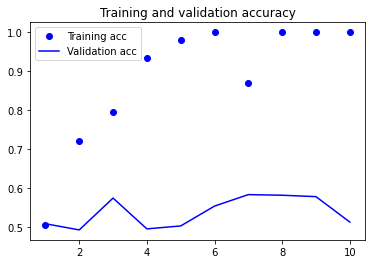

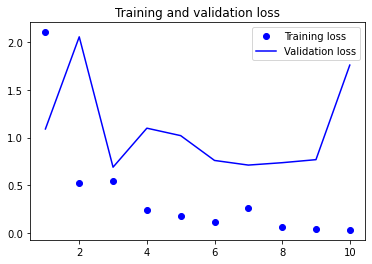

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- train acc는 높은데 validation acc는 50%로 낮은 것을 볼 수 있다. 


The model quickly starts overfitting, unsurprisingly given the small number of training samples. Validation accuracy has high variance for 
the same reason, but seems to reach high 50s.

Note that your mileage may vary: since we have so few training samples, performance is heavily dependent on which exact 200 samples we 
picked, and we picked them at random. If it worked really poorly for you, try picking a different random set of 200 samples, just for the 
sake of the exercise (in real life you don't get to pick your training data).

We can also try to train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. In that 
case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings 
when lots of data is available. However, in our case, we have only 200 training samples. Let's try it:

- 여기에서는 똑같은 예제를 Embedding layers를 풀어가지고 하면 어떻게 되는지를 본다. 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 1s 77ms/step - loss: 0.6897 - acc: 0.5586 - val_loss: 0.6940 - val_acc: 0.5032
Epoch 2/10
7/7 [==============================] - 0s 58ms/step - loss: 0.4914 - acc: 0.9584 - val_loss: 0.7071 - 

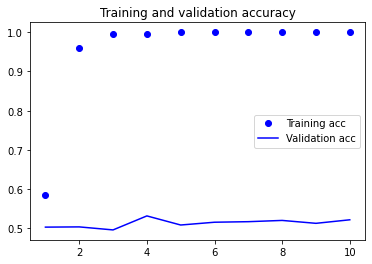

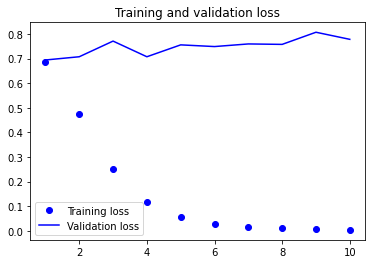

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Validation accuracy stalls in the low 50s. So in our case, pre-trained word embeddings does outperform jointly learned embeddings. If you 
increase the number of training samples, this will quickly stop being the case -- try it as an exercise.

Finally, let's evaluate the model on the test data. First, we will need to tokenize the test data:

In [ ]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

UnicodeDecodeError: 'cp949' codec can't decode byte 0xe2 in position 32: illegal multibyte sequence

And let's load and evaluate the first model:

In [ ]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.8344906200027465, 0.53608]

We get an appalling test accuracy of 54%. Working with just a handful of training samples is hard!

- 왜? 이렇게 성능이 안좋으냐면 샘플의 사이즈가 작기 때문에 성능이 좋지 않다는 것이 결론이다. 